# Gaussian sequence model

We observe a n-dimensional vector
y = mu + z
where z is a Gaussian random variable
with covariance sigma^2 I

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:


def generate_dataset(mu, sigma):
    """Generate a dataset according to the Gaussian sequence model
    with variance sigma^2 I

    Parameters
    ----------
    mu : array of size n
        Mean
    sigma : float
        Standard deviation

    Returns
    -------
    Y : array of size (n)
        Noisy observation
    """
    z = sigma * np.random.randn(len(mu))
    return mu + z

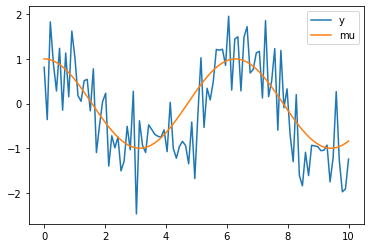

In [3]:


def cosine_dataset():
    """Take a grid of n=100 points between 0 and 10, take
    mu[i] = cos(i) where i is the value of each point
    and generate a dataset according to the Gaussian sequence
    model with sigma^2 = 0.5

    Return
    ------
    mu : array of size n
        Mean
    sigma : float
        Standard deviation
    y : array of size (n)
        Noisy observation
    grid : array of size n
        The grid used to generate mu
    """
    n = 100
    sigma = np.sqrt(0.5)
    grid = 10 * np.linspace(0, 1, num=n)
    mu = np.cos(grid)
    y = generate_dataset(mu, sigma)
    return mu, sigma, y, grid

def plot_dataset():
    """
    Plot on the same graph mu in function of i and Y in function
    of i (taking sigma^2 = 0.5)
    """
    mu, sigma, y, grid = cosine_dataset()
    plt.figure()
    plt.plot(grid, y, label="y")
    plt.plot(grid, mu, label="mu")
    plt.legend()
    plt.show()

plot_dataset()

# Shrinkage by a constant

Take the estimator muh = s y where s is a real between 0, 1

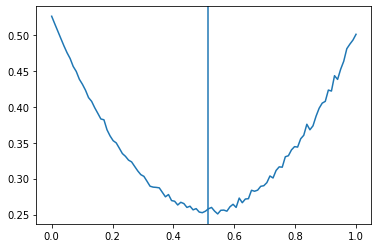

In [4]:

mu, sigma, _, _ = cosine_dataset()

def shrinkage(y, s):
    """ The shrinkage estimator
    Observe y and returns s * y
    Parameters
    -----------
    y: array of size n
        Observation
    Return
    ------
    sy: array of size n
        Shrinked observations
    """
    return s * y

def expected_error(mu_h, mu, sigma, n_trials):
    """
    Compute the expected error between mu_h and mu
    for a number (trials) of different datasets
    (with the same mean mu)

    Parameters
    ----------
    mu_h: function from an array of size n to an array of size n
        Estimator of mu
    mu: array of size n
        True value of mu
    n_trials: int
        Number of trials

    Return
    ------
    E: float
        Expected mean squared error of mu_h
    """
    errors = []
    for _ in range(n_trials):
        y = generate_dataset(mu, sigma)
        errors.append((mu_h(y) - mu)**2)
    return np.mean(errors)



def plot_shrinkage():
    """
    Take s in a grid between 0 and 1 with 100 points.
    Plot in function of s the mean squared error of
    the shrinkage estimator.
    Plot a vertical line at the maximum value
    s =  1/(1 + n sigma^2 / (|mu|^2)) where the norm is the l2 norm
    """
    n = 100
    grid = np.linspace(0, 1, num=100)
    error = []
    plt.figure()
    for s in grid:
        error.append(expected_error(lambda y: shrinkage(y, s), mu, sigma, 100))
    plt.plot(grid, error)
    plt.axvline(1/(1 + n *sigma **2 / np.sum(mu**2)))
    plt.show()

plot_shrinkage()

In [5]:


def akaike(A, y, sigma):
    """
    Compute the akaike estimator of the error of mu_hat = Ay
    Recall that it is given by
    ||mu_hat - y ||^2 + 2 sigma^2 tr(A) - sigma^2 n

    Parameters
    -----------
    A: array of shape (n, n)
    y: array of shape n
    sigma: float

    Return
    -------
    akaike: float
    """
    n = len(y)
    return np.sum((A.dot(y) - y)**2) + 2 * sigma**2 * np.trace(A) - sigma**2 * n


def linear_regression_coefficients(X, y):
    """
    Return argmin_b ||Xb - y ||^2

    Parameters
    ----------
    X : array of shape (n, p)
        Design matrix

    y: array of shape n
        Observation

    Return
    ------
    b: array of shape p
        regression coefficients
    """
    return (np.linalg.inv(X.T.dot(X))).dot(X.T).dot(y)


def linear_regression_operator(X):
    """
    Return A such that  argmin_b ||Xb - y ||^2 = Ay

    Parameters
    ----------
    X : array of shape (n, p)
        Design matrix

    Return
    ------
    A: array of shape n, n
        linear regression operator
    """
    return X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)


def akaike_regression(X, y, sigma):
    """ Akaike criterion for linear regression
    with design matrix X
    Find A such that Ay = b_hat = argmin_b || Xb - y ||^2
    Return the Akaike estimate of the error of y_hat = X b_hat

    Parameters
    ----------
    X : array
        Design matrix
    y: array of shape n
        Observation
    sigma: float
        standard deviation

    Return
    ------
    akaike : float
        The akaike estimate of the error of y_hat
    """
    return akaike(linear_regression_operator(X), y, sigma)


def select_best_3_features(X, y, sigma):
    """ Loop across features of X to find the best according to Akaike
    Consider all possible choice of 3 features across
    the number of features of X.
    For each choice of 3 features:
    - Build the matrix Xp which is of size (n, 3) and only contains
    the chosen features.
    - Compute the akaike regression criterion of Xp
    Return Xp which yields the lowest akaike regression criterion

    Parameters
    ---------
    X : array (n_samples, n_features)
        Design matrix
    y: array of shape n
        Observation
    sigma: float
        standard deviation

    Return
    -------
    S: boolean array (n_features,)
        S[i] = True if feature i is selected
        S has at exactly 3 non-False coefficients
    """
    n_samples, n_features = X.shape
    min_score = np.inf
    for indices in combinations(np.arange(n_features), 3):
        S = np.zeros(n_features)
        for index in indices:
            S[index] = 1
        S = S.astype(bool)
        Xs = X[:, S]
        score = akaike_regression(Xs, y, sigma)
        if score < min_score:
            S_min = S
            min_score = score
    return S_min


def test_diabetes():
    from sklearn.datasets import load_diabetes
    from sklearn.model_selection import train_test_split
    data = load_diabetes()
    X, y = data.data, data.target
    print(X.shape)
    X = np.column_stack([X, np.ones(len(X)).reshape(-1, 1)])
    print(X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
    S = select_best_3_features(X_train, y_train, sigma)
    b = linear_regression_coefficients(X_train, y_train)
    bS = linear_regression_coefficients(X_train[:, S], y_train)
    error = np.mean((X_test.dot(b) - y_test)**2)
    errorS = np.mean((X_test[:, S].dot(bS) - y_test)**2)
    print("Error without feature selection", error)
    print("Error with feature selection", errorS)
    assert errorS < error


test_diabetes()









(442, 10)
(442, 11)
Error without feature selection 3518.950717326987
Error with feature selection 3475.1978083895615


# Bonus

Take Ridge Regression min_b ||Xb - y ||^2 + lambda ||b||^2
And find the best lambda using akaike criterion

Check that it gives better results in practice (diabete dataset)